# Challenges with Heterogeneity: Binary Outcomes

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 23 | Notebook 1 of 2**

This notebook explores why treatment effect heterogeneity is especially challenging
with binary outcomes due to the S-curve nature of conversion functions.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

---

## 1. Intuition {#intuition}

### The Conversion Problem

**Common business scenario**:
- Treatment: Nudge (discount, voucher, free trial)
- Outcome: Binary conversion (app install, purchase, signup)
- Goal: Target customers with highest treatment effect

**The complication**: Conversion is bounded $Y \in \{0, 1\}$
- Cannot exceed 100%
- Cannot go below 0%
- Treatment effect depends on WHERE you are on the curve

### The S-Curve Insight

The probability of conversion follows a logistic (S-shaped) function:

$$P(Y=1|X) = \frac{1}{1 + e^{-\beta X}}$$

**Key property**: The derivative (treatment effect) varies with position:
- Near 0% or 100%: Low derivative → small treatment effects
- Near 50%: High derivative → large treatment effects

> **Received wisdom meets math**: "Don't target lost causes or sure wins."

---

## 2. Formal Treatment {#formal}

### 2.1 The Latent Variable Model

Consider a latent continuous outcome $Y^*$:

$$Y^* = \alpha + \beta X + \tau T + \gamma (T \times X) + \epsilon$$

The observed binary outcome:

$$Y = \mathbf{1}\{Y^* > c\}$$

### 2.2 Treatment Effect on Latent vs Binary

**Latent outcome** (linear):
$$\frac{\partial E[Y^*|X]}{\partial T} = \tau + \gamma X$$

**Binary outcome** (nonlinear):
$$\frac{\partial P(Y=1|X)}{\partial T} = \phi(\cdot) \cdot (\tau + \gamma X)$$

where $\phi(\cdot)$ is the PDF of the link function (logistic or normal).

### 2.3 The Derivative Problem

For logistic link:
$$\phi(z) = \frac{e^z}{(1+e^z)^2}$$

**Maximum at z=0** (50% baseline):
$$\phi(0) = 0.25$$

**Near extremes**:
$$\phi(z) \to 0 \text{ as } z \to \pm\infty$$

★ Even if true treatment effect modifier $\gamma$ is zero, baseline-predictive
variables create apparent heterogeneity through the derivative term.

---

## 3. Numeric Demonstration {#numeric}

### Data Generating Process

In [2]:
np.random.seed(123)

n = 100000

# Treatment: randomized nudge
nudge = np.random.binomial(1, 0.5, n)

# Covariates
age = np.random.gamma(10, 4, n)  # Age modifies treatment effect
income = np.random.gamma(20, 2, n) * 100  # Income predicts outcome but NOT effect

# Latent outcome: income predicts Y*, age modifies nudge effect
latent_outcome = np.random.normal(
    -4.5 + income * 0.001 + nudge + nudge * age * 0.01,
    scale=1.0
)

# Binary conversion (around 50% baseline)
conversion = (latent_outcome > 0.1).astype(int)

df = pd.DataFrame({
    'conversion': conversion,
    'nudge': nudge,
    'age': age,
    'income': income,
    'latent_outcome': latent_outcome
})

print(f"Average conversion: {df['conversion'].mean():.1%}")
print(f"Average age: {df['age'].mean():.1f}")
print(f"Average income: {df['income'].mean():.0f}")

Average conversion: 51.8%
Average age: 40.0
Average income: 3995


### Average Treatment Effects

In [3]:
def avg_treatment_effect(df, treatment, outcome):
    """Simple difference in means."""
    return df.loc[df[treatment] == 1, outcome].mean() - df.loc[df[treatment] == 0, outcome].mean()

# ATE on latent (linear) vs conversion (binary)
ate_latent = avg_treatment_effect(df, 'nudge', 'latent_outcome')
ate_conversion = avg_treatment_effect(df, 'nudge', 'conversion')

print(f"ATE on latent outcome: {ate_latent:.3f}")
print(f"Expected (1 + 0.01*40): {1 + 0.01*40:.3f}")
print(f"\nATE on conversion: {ate_conversion:.3f}")
print(f"  (Bounded by [0,1] so smaller than latent)")

ATE on latent outcome: 1.402
Expected (1 + 0.01*40): 1.400

ATE on conversion: 0.395
  (Bounded by [0,1] so smaller than latent)


### Cumulative Effect Curves

Compare: age (true effect modifier) vs income (baseline predictor only)

In [4]:
def cumulative_effect_curve(df, treatment, outcome, prediction, min_rows=500, steps=100):
    """Cumulative treatment effect as we include more units sorted by prediction."""
    size = df.shape[0]
    ordered_df = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_rows, size, size // steps)) + [size]
    return np.array([avg_treatment_effect(ordered_df.head(rows), treatment, outcome) 
                     for rows in n_rows])

In [5]:
# Cumulative effect curves for latent outcome
age_effect_latent = cumulative_effect_curve(df, 'nudge', 'latent_outcome', 'age')
income_effect_latent = cumulative_effect_curve(df, 'nudge', 'latent_outcome', 'income')

# Cumulative effect curves for conversion
age_effect_conv = cumulative_effect_curve(df, 'nudge', 'conversion', 'age')
income_effect_conv = cumulative_effect_curve(df, 'nudge', 'conversion', 'income')

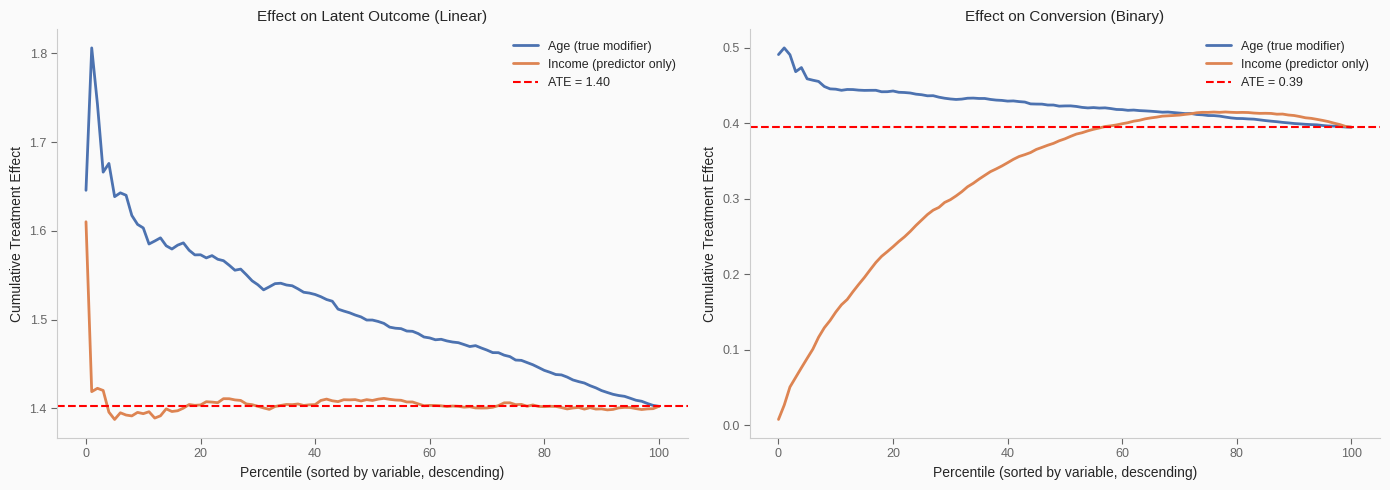

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latent outcome (linear - works as expected)
ax = axes[0]
ax.plot(age_effect_latent, label='Age (true modifier)', color=COLORS['blue'], linewidth=2)
ax.plot(income_effect_latent, label='Income (predictor only)', color=COLORS['orange'], linewidth=2)
ax.axhline(ate_latent, color='red', linestyle='--', label=f'ATE = {ate_latent:.2f}')
ax.set_xlabel('Percentile (sorted by variable, descending)')
ax.set_ylabel('Cumulative Treatment Effect')
ax.set_title('Effect on Latent Outcome (Linear)')
ax.legend()
apply_tufte_style(ax)

# Conversion (binary - S-curve complication)
ax = axes[1]
ax.plot(age_effect_conv, label='Age (true modifier)', color=COLORS['blue'], linewidth=2)
ax.plot(income_effect_conv, label='Income (predictor only)', color=COLORS['orange'], linewidth=2)
ax.axhline(ate_conversion, color='red', linestyle='--', label=f'ATE = {ate_conversion:.2f}')
ax.set_xlabel('Percentile (sorted by variable, descending)')
ax.set_ylabel('Cumulative Treatment Effect')
ax.set_title('Effect on Conversion (Binary)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

```
★ Insight ─────────────────────────────────────────────────────
For the LATENT outcome (left): 
- Age shows heterogeneity (as expected - it modifies effect)
- Income is flat around ATE (correctly - no effect modification)

For CONVERSION (right):
- Age still shows some heterogeneity
- Income shows HUGE heterogeneity despite NOT modifying effect!

Why? Income predicts baseline → different position on S-curve → 
different derivative → apparent treatment effect heterogeneity.
──────────────────────────────────────────────────────────────
```

### The S-Curve Effect

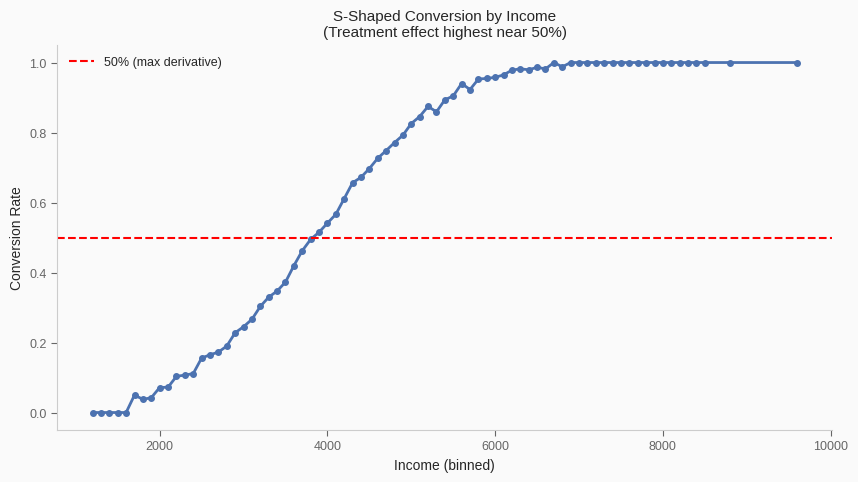

In [7]:
# Show S-curve relationship
income_bins = (df['income'] / 100).astype(int) * 100
conversion_by_income = df.assign(income_bin=income_bins).groupby('income_bin')['conversion'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(conversion_by_income.index, conversion_by_income.values, 'o-', 
        color=COLORS['blue'], linewidth=2, markersize=4)
ax.axhline(0.5, color='red', linestyle='--', label='50% (max derivative)')
ax.set_xlabel('Income (binned)')
ax.set_ylabel('Conversion Rate')
ax.set_title('S-Shaped Conversion by Income\n(Treatment effect highest near 50%)')
ax.legend()
apply_tufte_style(ax)
plt.show()

### Low vs High Baseline Conversion Scenarios

In [8]:
# Create low and high conversion scenarios
df['conversion_low'] = (df['latent_outcome'] > 2).astype(int)  # ~12%
df['conversion_high'] = (df['latent_outcome'] > -2).astype(int)  # ~93%

print(f"Low conversion baseline: {df['conversion_low'].mean():.1%}")
print(f"High conversion baseline: {df['conversion_high'].mean():.1%}")

Low conversion baseline: 12.1%
High conversion baseline: 92.8%


In [9]:
# Cumulative effects for both scenarios
income_effect_low = cumulative_effect_curve(df, 'nudge', 'conversion_low', 'income')
income_effect_high = cumulative_effect_curve(df, 'nudge', 'conversion_high', 'income')

ate_low = avg_treatment_effect(df, 'nudge', 'conversion_low')
ate_high = avg_treatment_effect(df, 'nudge', 'conversion_high')

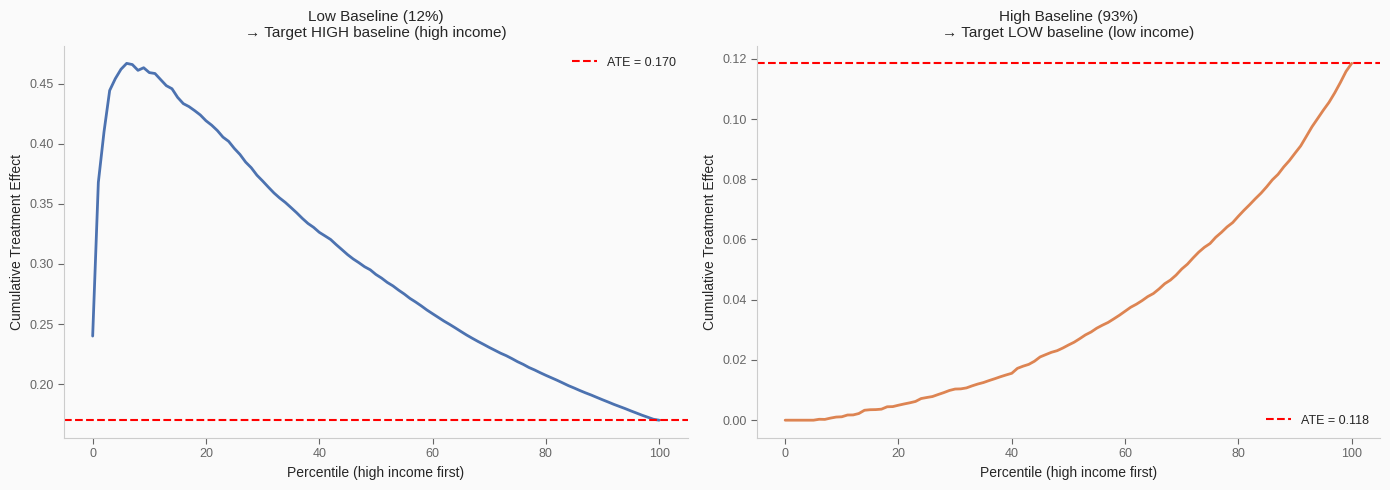

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Low conversion scenario
ax = axes[0]
ax.plot(income_effect_low, color=COLORS['blue'], linewidth=2)
ax.axhline(ate_low, color='red', linestyle='--', label=f'ATE = {ate_low:.3f}')
ax.set_xlabel('Percentile (high income first)')
ax.set_ylabel('Cumulative Treatment Effect')
ax.set_title(f'Low Baseline ({df["conversion_low"].mean():.0%})\n→ Target HIGH baseline (high income)')
ax.legend()
apply_tufte_style(ax)

# High conversion scenario
ax = axes[1]
ax.plot(income_effect_high, color=COLORS['orange'], linewidth=2)
ax.axhline(ate_high, color='red', linestyle='--', label=f'ATE = {ate_high:.3f}')
ax.set_xlabel('Percentile (high income first)')
ax.set_ylabel('Cumulative Treatment Effect')
ax.set_title(f'High Baseline ({df["conversion_high"].mean():.0%})\n→ Target LOW baseline (low income)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

---

## 4. Implementation {#implementation}

### Targeting Strategy Summary

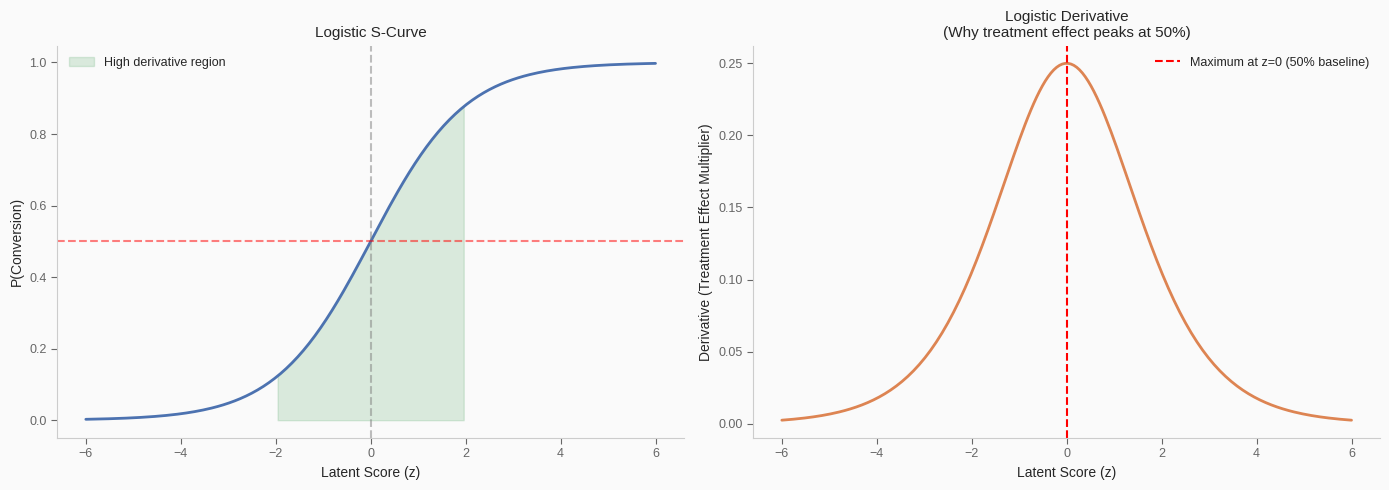

In [11]:
# Show the logistic derivative
z = np.linspace(-6, 6, 200)
sigmoid = 1 / (1 + np.exp(-z))
derivative = sigmoid * (1 - sigmoid)  # φ(z) = σ(z)(1-σ(z))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# S-curve
ax = axes[0]
ax.plot(z, sigmoid, color=COLORS['blue'], linewidth=2)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Latent Score (z)')
ax.set_ylabel('P(Conversion)')
ax.set_title('Logistic S-Curve')
ax.fill_between(z, 0, sigmoid, where=(z > -2) & (z < 2), alpha=0.2, color=COLORS['green'],
                label='High derivative region')
ax.legend()
apply_tufte_style(ax)

# Derivative (treatment effect multiplier)
ax = axes[1]
ax.plot(z, derivative, color=COLORS['orange'], linewidth=2)
ax.axvline(0, color='red', linestyle='--', label='Maximum at z=0 (50% baseline)')
ax.set_xlabel('Latent Score (z)')
ax.set_ylabel('Derivative (Treatment Effect Multiplier)')
ax.set_title('Logistic Derivative\n(Why treatment effect peaks at 50%)')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

In [12]:
# Practical targeting rule
targeting_rules = pd.DataFrame({
    'Baseline Conversion': ['Low (<30%)', 'Medium (30-70%)', 'High (>70%)'],
    'Position on S-curve': ['Left tail', 'Middle', 'Right tail'],
    'Targeting Strategy': [
        'Target HIGH baseline (closer to 50%)',
        'Any baseline works well',
        'Target LOW baseline (closer to 50%)'
    ],
    'Business Translation': [
        'Target "warm leads"',
        'Broad targeting OK',
        'Target "at-risk" customers'
    ]
})

print("Targeting Rules for Binary Outcomes:")
print(targeting_rules.to_string(index=False))

Targeting Rules for Binary Outcomes:
Baseline Conversion Position on S-curve                   Targeting Strategy       Business Translation
         Low (<30%)           Left tail Target HIGH baseline (closer to 50%)        Target "warm leads"
    Medium (30-70%)              Middle              Any baseline works well         Broad targeting OK
        High (>70%)          Right tail  Target LOW baseline (closer to 50%) Target "at-risk" customers


```
★ Key Takeaway ────────────────────────────────────────────────
For binary outcomes with treatment effect heterogeneity:

**Simple rule**: Target whoever is closer to 50% baseline conversion.

This rule dominates because:
1. Logistic derivative maximized at 50%
2. True effect modifiers often weaker than curvature effect
3. Matches marketing intuition (no "lost causes" or "sure wins")
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: Why is CATE estimation harder with binary outcomes?

<details>
<summary>Solution</summary>

**Core issue**: Binary outcomes are bounded [0,1], creating S-curve.

**Consequences**:
1. Treatment effect depends on baseline position
2. Variables that predict outcome (not effect) create apparent heterogeneity
3. True effect modifiers may be dominated by curvature

**Mathematical reason**:
- Effect = $\phi(z) \cdot \tau$ where $\phi(z)$ is derivative
- $\phi(z)$ maximized at $z=0$ (50% baseline)
- Near extremes (0% or 100%), $\phi(z) \approx 0$

**Practical implication**: 
Variables predicting baseline may be better for targeting than 
variables that truly modify effects.

</details>

### Q2: A/B test shows nudge increases conversion. Who should get it?

<details>
<summary>Solution</summary>

**Framework**:
1. Check baseline conversion rate
2. If low (< 30%): Target high-propensity customers
3. If high (> 70%): Target low-propensity customers
4. If medium: Any targeting may work

**Simple rule**: Target those closest to 50% baseline.

**Caveats**:
- Consider cost structure (nudge cost vs customer value)
- Check for true effect modifiers beyond baseline
- Validate with holdout before full rollout

**Warning**: Don't just target everyone or no one—
treatment effect varies dramatically across the S-curve.

</details>

### Q3: How does this relate to COVID vaccine prioritization?

<details>
<summary>Solution</summary>

**Setup**:
- Treatment: Vaccine
- Outcome: Death/hospitalization (binary, low baseline)
- Question: Who benefits most?

**Analysis**:
- Mortality rate < 50% (left side of S-curve)
- Maximum effect near 50% baseline
- Therefore: Target those with HIGH baseline risk

**Result**: Elderly and immunocompromised prioritized.

This matches both:
- Intuition (protect vulnerable)
- Mathematics (derivative highest near 50%)

**Note**: This is one factor among many (transmission, supply, etc.)

</details>

---

## 6. References {#references}

[^1]: Fernández-Loría, C., & Provost, F. (2022). Causal Classification: Treatment Effect Estimation 
      vs. Outcome Prediction. *Journal of Machine Learning Research*.

[^2]: Athey, S., & Imbens, G. W. (2017). The State of Applied Econometrics: Causality and Policy 
      Evaluation. *Journal of Economic Perspectives*, 31(2), 3-32.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 23.